В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [108]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [4]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, normalize = True, learning_rate = 0.01, num_iter = 30000,num_node=[20,1],accuracy=0.00001,lmbd=0.1,beta=0.5,eps=1e-8):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.num_layer=len(num_node)
        self.num_node=num_node
        self.accuracy=accuracy
        self.lmbd=lmbd
        self.beta=beta;
        self.eps=eps;
        self.W=None
        self.b=None
        self.Z=None
        self.A=None
        self.dW=None
        self.db=None
        self.dZ=None
        self.dA=None
        self.SdW=None
        self.Sdb=None
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
#         m = X.shape[1]
        
#         u=mean
#         if u==None: u= np.sum(X,axis=1)/m
#         s=std    
#         if s==None:s=np.sqrt(np.sum((X-np.vstack(u))**2))
       
        
#         X_new=(X-np.vstack(u)(/(s**2)
        
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    
    def __softmax(self, Z):
        return np.exp(Z) / np.sum(np.exp(Z)) 
    
    def __initialize_parameters(self, n_x):
        
        
        self.W=[]
        self.SdW=[]
        
        self.W.append(list(np.random.randn(self.num_node[0], n_x)/np.sqrt(n_x)))
        self.b=[np.zeros((self.num_node[i], 1)) for i in range(self.num_layer)]
        self.W=self.W+[list((np.random.randn(self.num_node[i],self.num_node[i-1])*
                             np.sqrt(1/(self.num_node[i-1]+self.num_node[i])))) for i in range(1,self.num_layer)]
        
        self.SdW.append(list(np.zeros((self.num_node[0], n_x))))
        self.SdW=self.SdW+[list(np.zeros((self.num_node[i],self.num_node[i-1]))) for i in range(1,self.num_layer)]
        self.Sdb=[np.zeros((self.num_node[i], 1)) for i in range(self.num_layer)]

       
    def __forward_propagation(self, X):

        self.Z=[]
        self.A=[]
        self.Z.append(np.dot(self.W[0], X) + self.b[0])
        self.A.append(self.__sigmoid(self.Z[0]))

        for i in range(1,len(self.W)-1):
            self.Z.append(np.dot(self.W[i], self.A[i-1]) + self.b[i])
            self.A.append(self.__softmax(self.Z[i]))
            
        self.Z.append(np.dot(self.W[-1], self.A[-1]) + self.b[-1])
        self.A.append(self.__sigmoid(self.Z[-1]))
        
        return self.A[-1]
    

        
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        norm = 0
        for i in range(self.num_layer):
            norm += np.linalg.norm(self.W[i], ord = 'fro')
        J = -(1 / m) * np.sum(res)+self.lmbd*norm/(2*m)
        return J
        
    def __backward_propagation(self, X, Y):
        m = X.shape[1]
        n = X.shape[0]
        W, b,Z, A=self.W,self.b,self.Z,self.A

      
        self.dW,self.db,self.dZ,self.dA=[],[],[],[]
        self.dZ.append(A[-1] - Y)
        self.dW.append(1. / m * np.dot(self.dZ[-1], A[-2].T))
        self.db.append(1. / m * np.sum(self.dZ[-1], axis = 1, keepdims = True))
        self.dA.append(np.dot(np.array(W[-1]).T, self.dZ[-1]))       


            

        for i in range(self.num_layer-1):
            self.dZ.append(np.multiply(self.dA[i], np.multiply(A[self.num_layer-2-i], 1 - A[self.num_layer-2-i])))
            if(self.num_layer-3-i>=0):
                self.dW.append( 1. / m * np.dot(self.dZ[i+1], A[self.num_layer-3-i].T))
            else:
                self.dW.append( 1. / m * np.dot(self.dZ[i+1], X.T))
            self.db.append( 1. / m * np.sum(self.dZ[i+1], axis = 1, keepdims = True))
            self.dA.append(np.dot(np.array(W[self.num_layer-2-i]).T, self.dZ[i+1]))
       
        self.dW.reverse()
        self.db.reverse()
        self.dZ.reverse()
        self.dA.reverse()

    
    def __update_parameters(self,m):
        for i in range(self.num_layer):
            self.SdW[i]=self.beta*np.array(self.SdW[i])+(1-self.beta)*np.power(self.dW[i],2)
            self.Sdb[i]=self.beta*np.array(self.Sdb[i])+(1-self.beta)*np.power(self.db[i],2)
#             self.SdW = [np.array(i, dtype=float) for i in self.SdW]
            self.W[i] = self.W[i] - self.learning_rate * self.dW[i]/( np.sqrt(self.SdW[i]) +self.eps)
            self.b[i] = self.b[i] - self.learning_rate * self.db[i]/( np.sqrt(self.Sdb[i]) +self.eps)

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        check = []
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters(n_x)
 
        for i in range(self.num_iter):
            A = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)
            self.__backward_propagation(X, Y)

            self.__update_parameters(m)
        
            check.append(cost)
            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 10 == 0:
                costs.append(cost)
                
            if(len(check)>2 and abs(check[i]-check[i-1])<self.accuracy):
                break

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [115]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


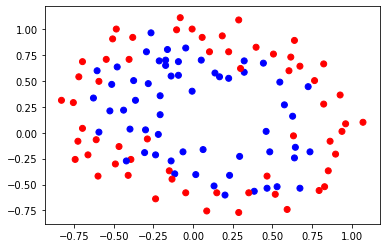

In [116]:
plot_data(X, Y)

In [117]:
cls = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 3000,num_node=[5,20,],accuracy=1e-8)

0-th iteration: 13.981083456939675
1000-th iteration: 8.416816176583719
2000-th iteration: 7.9794618421845955


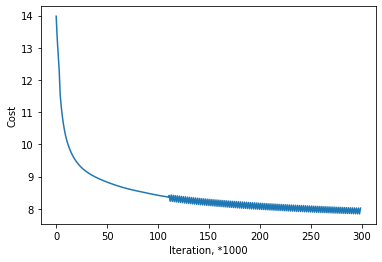

In [118]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [119]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[0.34094547, 0.65905453],
       [0.20375737, 0.79624263],
       [0.07224541, 0.92775459],
       [0.14704067, 0.85295933],
       [0.05042061, 0.94957939],
       [0.95338173, 0.04661827],
       [0.05041972, 0.94958028],
       [0.34094554, 0.65905446],
       [0.34305128, 0.65694872],
       [0.95342613, 0.04657387],
       [0.95342701, 0.04657299],
       [0.05137474, 0.94862526],
       [0.13945234, 0.86054766],
       [0.13955317, 0.86044683],
       [0.94993813, 0.05006187],
       [0.34093632, 0.65906368],
       [0.5459409 , 0.4540591 ],
       [0.34094555, 0.65905445],
       [0.94986885, 0.05013115],
       [0.00202854, 0.99797146],
       [0.95342701, 0.04657299],
       [0.9533875 , 0.0466125 ],
       [0.95333605, 0.04666395],
       [0.13945998, 0.86054002],
       [0.07024248, 0.92975752],
       [0.95338931, 0.04661069],
       [0.05167224, 0.94832776],
       [0.07542736, 0.92457264],
       [0.11623428, 0.88376572],
       [0.78888288, 0.21111712],
       [0.

In [120]:
Y_hat = cls.predict(X)
Y_hat

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0])

In [121]:
accuracy_score(Y, Y_hat)

0.8220338983050848

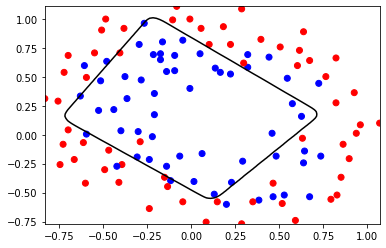

In [122]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [126]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (5,20), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [127]:
clf.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 20), learning_rate='constant',
              learning_rate_init=0.01, max_iter=10000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

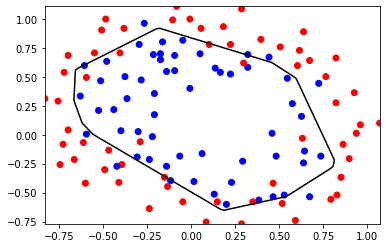

In [128]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [129]:
accuracy_score(Y, clf.predict(X))

0.8559322033898306

In [130]:
data_columns = ["exam1", "exam2"]
target_column = "submitted"
df = pd.read_csv("sats.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(100, 2), y=(100,)


In [131]:
cls = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 3000,num_node=[5,20,],accuracy=1e-8)

0-th iteration: 14.047996459305905
1000-th iteration: 1.807267461871559
2000-th iteration: 1.1821725208260694


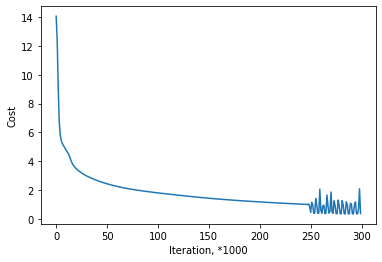

In [132]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [133]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[3.54287542e-07, 9.99999646e-01],
       [2.71186496e-26, 1.00000000e+00],
       [2.02256161e-07, 9.99999798e-01],
       [1.00000000e+00, 1.28785871e-14],
       [1.00000000e+00, 9.76996262e-15],
       [8.74420801e-16, 1.00000000e+00],
       [1.00000000e+00, 1.02140518e-14],
       [9.66820646e-01, 3.31793543e-02],
       [1.00000000e+00, 9.76996262e-15],
       [8.88687181e-01, 1.11312819e-01],
       [9.50503421e-03, 9.90494966e-01],
       [1.44430509e-11, 1.00000000e+00],
       [1.00000000e+00, 9.76996262e-15],
       [1.00000000e+00, 9.76996262e-15],
       [1.80034735e-06, 9.99998200e-01],
       [1.00000000e+00, 3.37507799e-14],
       [9.99999970e-01, 3.02083745e-08],
       [4.33380786e-05, 9.99956662e-01],
       [1.00000000e+00, 9.76996262e-15],
       [9.99915579e-01, 8.44206032e-05],
       [9.12989828e-12, 1.00000000e+00],
       [1.00000000e+00, 9.99200722e-15],
       [2.24455387e-22, 1.00000000e+00],
       [3.68308592e-26, 1.00000000e+00],
       [1.000000

In [134]:
Y_hat = cls.predict(X)
Y_hat

array([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [135]:
accuracy_score(Y, Y_hat)

1.0

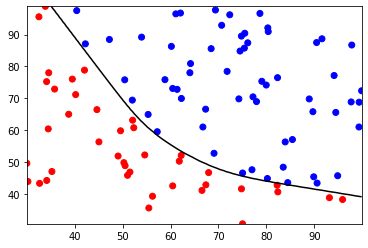

In [136]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

In [145]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 50,))

In [146]:
clf.fit(X, Y)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

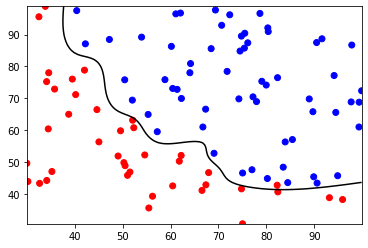

In [147]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [148]:
accuracy_score(Y, clf.predict(X))

0.99